# Import Library

In [ ]:
pip install scikeras[tensorflow]


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import gensim
from wordcloud import WordCloud, STOPWORDS
from gensim.models import KeyedVectors
import gensim.models.keyedvectors as word2vec
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Activation, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Reshape, Flatten, Concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
from keras.models import model_from_json
import pickle
import json
import logging

logging.basicConfig(format = '%(asctime)s : %(levelname) s : %(message)s', level = logging.INFO)

print('ALL LIBRARY IMPORTED.')

from google.colab import drive
drive.mount('/content/drive')

ALL LIBRARY IMPORTED.


# Load & Preprocess Data

In [ ]:
df = pd.read_csv('drive/Sentyment Analysis using Boosting/tweets_data.csv')
print('Data loaded.\n')

Data loaded.



In [ ]:
df.drop('Unnamed: 0', axis=1, inplace = True)
df.dropna(inplace = True)

## Take random 10.000 data from each labels, total 20.000 data

In [ ]:
df_1 = df[df['label'] == 1]
df_0 = df[df['label'] == 0]

df_1 = df_1.sample(n = 10000)
df_0 = df_0.sample(n = 10000)

In [ ]:
df = pd.concat([df_1, df_0], ignore_index = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   20000 non-null  object
 1   label   20000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


In [ ]:
df['label'].value_counts()

1    10000
0    10000
Name: label, dtype: int64

# Build Corpus

In [ ]:
# Frequent words removal
freq = ['rt','im','ð','ðð','ððð','ðððð','ððððð','amp','u','â','retweet']
df['tweet_punc_remv'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
df.drop('tweet', axis = 1, inplace = True)
df = df.rename(columns = {'tweet_punc_remv':'tweet'})

# Membuat korpus
corpus = df['tweet'].apply(gensim.utils.simple_preprocess)

# Memberi indeks pada teks
token = Tokenizer()
token.fit_on_texts(corpus)
token.index_word
token.texts_to_sequences(corpus)

#Jumlah kata dalam korpus
vocal = len(token.index_word)+1
print('There are {} words.'.format(vocal))

There are 24447 words.


# Defining X and Y & Pad sequences

In [ ]:
maxword = 30
X = token.texts_to_sequences(corpus)
X = pad_sequences(X, maxlen = maxword, padding = 'post')
y = df['label'].values.tolist()
print('X and y defined')

X and y defined


# Splitting data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state = 42)
print('Training and testing data defined.')

Training and testing data defined.


In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
print('Done')

Done


# Glove

## Embedding layer

In [ ]:
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = 'drive/Sentyment Analysis using Boosting/glove.6B.300d.txt'
word2vec_output_file = 'drive/Sentyment Analysis using Boosting/word2vec.txt'
# The first step is to convert the GloVe file format to the word2vec file format. 
# The only difference is the addition of a small header line. This can be done by calling the 
# glove2word2vec() function.
glove2word2vec(glove_input_file, word2vec_output_file)

C:\Users\MSI\AppData\Local\Temp\ipykernel_17692\2779252760.py:8: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)
2022-08-12 08:12:12,378 : INFO : loading projection weights from glove.6B.300d.txt
2022-08-12 08:13:25,813 : INFO : KeyedVectors lifecycle event {'msg': 'loaded (400000, 300) matrix of type float32 from glove.6B.300d.txt', 'binary': False, 'encoding': 'utf8', 'datetime': '2022-08-12T08:13:25.813264', 'gensim': '4.2.0', 'python': '3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'load_word2vec_format'}
2022-08-12 08:13:25,813 : INFO : converting 400000 vectors from glove.6B.300d.txt to word2vec.txt
2022-08-12 08:13:26,079 : INFO : storing 400000x300 projection weights into word2vec.txt


(400000, 300)

In [ ]:
from gensim.models import KeyedVectors
glove = KeyedVectors.load_word2vec_format(glove2word2vec, binary = False, limit = 150000)

2022-08-12 08:14:16,630 : INFO : loading projection weights from word2vec.txt
2022-08-12 08:14:44,122 : INFO : KeyedVectors lifecycle event {'msg': 'loaded (150000, 300) matrix of type float32 from word2vec.txt', 'binary': False, 'encoding': 'utf8', 'datetime': '2022-08-12T08:14:44.122986', 'gensim': '4.2.0', 'python': '3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'load_word2vec_format'}


In [ ]:
embedding_layer = Embedding(input_dim = 150000, output_dim = 300, weights = [glove.vectors], 
                            input_length = X.shape[1],trainable = False)
print('Embedding layer defined.')

Embedding layer defined.


## Hyperparameter Tuning Parameter Model Glove

In [ ]:
def get_model_cnn_2(learning_rate = 0.01):

  #Define model
    model = Sequential()
    model.add(embedding_layer)
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Conv1D(filters = 256, kernel_size = 5, padding = 'same', activation = 'relu'))
    model.add(MaxPooling1D(pool_size = 3))
    model.add(BatchNormalization())
    model.add(Conv1D(filters = 128, kernel_size = 5, padding = 'same', activation = 'relu'))
    model.add(MaxPooling1D(pool_size = 3))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(64,activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid'))
 
    #Compile model
    adam = Adam(learning_rate = 0.01)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

    return model

In [ ]:
%%time
# Early Stopping
monitor = EarlyStopping(monitor = 'val_loss', mode = 'max', patience = 10)

# Memdefinisikan Model
model_cnn_2 = KerasClassifier(model = get_model_cnn_2,
                             callbacks = [monitor],
                             learning_rate = 0.01, verbose = 1)

# define the grid search parameters
params_cnn_2 = {'batch_size': [32,64,128],
              'learning_rate': [0.01,0.001],
              'epochs': [50,100]}

ht_cnn_2 = GridSearchCV(model_cnn_2,
                       param_grid = params_cnn_2,
                       scoring = 'accuracy')

hyt_cnn_2 = ht_cnn_2.fit(X_train, y_train, validation_data = (X_test, y_test));
print("\nThe best parameter is {}".format(hyt_cnn_2.best_params_))
print("\nThe best_accuracy is {}".format(hyt_cnn_2.best_score_))

Epoch 1/50
375/375 [==============================] - 9s 21ms/step - loss: 0.5590 - accuracy: 0.7282 - val_loss: 0.4601 - val_accuracy: 0.7836
Epoch 2/50
375/375 [==============================] - 8s 21ms/step - loss: 0.3555 - accuracy: 0.8444 - val_loss: 0.2760 - val_accuracy: 0.8846
Epoch 3/50
375/375 [==============================] - 8s 21ms/step - loss: 0.2503 - accuracy: 0.8961 - val_loss: 0.2733 - val_accuracy: 0.8858
Epoch 4/50
375/375 [==============================] - 8s 21ms/step - loss: 0.1853 - accuracy: 0.9276 - val_loss: 0.2603 - val_accuracy: 0.8944
Epoch 5/50
375/375 [==============================] - 8s 22ms/step - loss: 0.1479 - accuracy: 0.9446 - val_loss: 0.3755 - val_accuracy: 0.8438
Epoch 6/50
375/375 [==============================] - 8s 21ms/step - loss: 0.1162 - accuracy: 0.9586 - val_loss: 0.3383 - val_accuracy: 0.8858
Epoch 7/50
375/375 [==============================] - 8s 21ms/step - loss: 0.1011 - accuracy: 0.9625 - val_loss: 0.3549 - val_accuracy: 0.8954

375/375 [==============================] - 8s 21ms/step - loss: 0.0828 - accuracy: 0.9715 - val_loss: 0.3262 - val_accuracy: 0.9032
Epoch 10/50
375/375 [==============================] - 8s 21ms/step - loss: 0.0785 - accuracy: 0.9706 - val_loss: 0.3752 - val_accuracy: 0.8950
Epoch 11/50
375/375 [==============================] - 8s 22ms/step - loss: 0.0743 - accuracy: 0.9733 - val_loss: 0.4049 - val_accuracy: 0.8946
Epoch 12/50
375/375 [==============================] - 8s 21ms/step - loss: 0.0587 - accuracy: 0.9796 - val_loss: 0.3317 - val_accuracy: 0.8900
Epoch 13/50
375/375 [==============================] - 8s 21ms/step - loss: 0.0694 - accuracy: 0.9768 - val_loss: 0.3465 - val_accuracy: 0.8978
Epoch 14/50
375/375 [==============================] - 8s 21ms/step - loss: 0.0567 - accuracy: 0.9818 - val_loss: 0.3892 - val_accuracy: 0.8962
Epoch 15/50
375/375 [==============================] - 8s 21ms/step - loss: 0.0620 - accuracy: 0.9784 - val_loss: 0.3626 - val_accuracy: 0.9040
Epoc

Epoch 4/50
375/375 [==============================] - 8s 22ms/step - loss: 0.1863 - accuracy: 0.9267 - val_loss: 0.3035 - val_accuracy: 0.8844
Epoch 5/50
375/375 [==============================] - 8s 21ms/step - loss: 0.1568 - accuracy: 0.9401 - val_loss: 0.3256 - val_accuracy: 0.8708
Epoch 6/50
375/375 [==============================] - 8s 21ms/step - loss: 0.1139 - accuracy: 0.9574 - val_loss: 0.3202 - val_accuracy: 0.8972
Epoch 7/50
375/375 [==============================] - 8s 21ms/step - loss: 0.1073 - accuracy: 0.9582 - val_loss: 0.3090 - val_accuracy: 0.9010
Epoch 8/50
375/375 [==============================] - 8s 22ms/step - loss: 0.0956 - accuracy: 0.9638 - val_loss: 0.3630 - val_accuracy: 0.8708
Epoch 9/50
375/375 [==============================] - 8s 22ms/step - loss: 0.0849 - accuracy: 0.9695 - val_loss: 0.3086 - val_accuracy: 0.8966
Epoch 10/50
375/375 [==============================] - 8s 22ms/step - loss: 0.0694 - accuracy: 0.9772 - val_loss: 0.3407 - val_accuracy: 0.898

375/375 [==============================] - 8s 22ms/step - loss: 0.0779 - accuracy: 0.9719 - val_loss: 0.3968 - val_accuracy: 0.8928
Epoch 10/100
375/375 [==============================] - 8s 22ms/step - loss: 0.0770 - accuracy: 0.9720 - val_loss: 0.3378 - val_accuracy: 0.8968
Epoch 11/100
94/94 [==============================] - 1s 5ms/step
Epoch 1/100
375/375 [==============================] - 9s 22ms/step - loss: 0.5743 - accuracy: 0.7190 - val_loss: 0.5465 - val_accuracy: 0.7142
Epoch 2/100
375/375 [==============================] - 8s 21ms/step - loss: 0.3508 - accuracy: 0.8488 - val_loss: 0.2873 - val_accuracy: 0.8818
Epoch 3/100
375/375 [==============================] - 8s 22ms/step - loss: 0.2578 - accuracy: 0.8949 - val_loss: 0.2688 - val_accuracy: 0.8884
Epoch 4/100
375/375 [==============================] - 8s 21ms/step - loss: 0.2006 - accuracy: 0.9201 - val_loss: 0.2654 - val_accuracy: 0.8936
Epoch 5/100
375/375 [==============================] - 8s 22ms/step - loss: 0.145

375/375 [==============================] - 8s 22ms/step - loss: 0.0611 - accuracy: 0.9787 - val_loss: 0.3498 - val_accuracy: 0.8936
Epoch 12/100
375/375 [==============================] - 8s 22ms/step - loss: 0.0636 - accuracy: 0.9782 - val_loss: 0.3528 - val_accuracy: 0.8890
Epoch 13/100
375/375 [==============================] - 8s 21ms/step - loss: 0.0655 - accuracy: 0.9766 - val_loss: 0.3762 - val_accuracy: 0.8964
Epoch 14/100
375/375 [==============================] - 8s 22ms/step - loss: 0.0593 - accuracy: 0.9783 - val_loss: 0.3352 - val_accuracy: 0.9018
Epoch 15/100
375/375 [==============================] - 8s 21ms/step - loss: 0.0499 - accuracy: 0.9833 - val_loss: 0.3560 - val_accuracy: 0.8980
Epoch 16/100
375/375 [==============================] - 8s 22ms/step - loss: 0.0502 - accuracy: 0.9812 - val_loss: 0.4153 - val_accuracy: 0.8990
Epoch 17/100
375/375 [==============================] - 8s 21ms/step - loss: 0.0495 - accuracy: 0.9837 - val_loss: 0.3498 - val_accuracy: 0.897

375/375 [==============================] - 8s 22ms/step - loss: 0.0837 - accuracy: 0.9689 - val_loss: 0.3172 - val_accuracy: 0.8912
Epoch 10/100
375/375 [==============================] - 8s 22ms/step - loss: 0.0779 - accuracy: 0.9714 - val_loss: 0.3472 - val_accuracy: 0.8976
Epoch 11/100
94/94 [==============================] - 1s 6ms/step
Epoch 1/100
375/375 [==============================] - 9s 22ms/step - loss: 0.5734 - accuracy: 0.7165 - val_loss: 0.5315 - val_accuracy: 0.7322
Epoch 2/100
375/375 [==============================] - 8s 22ms/step - loss: 0.3530 - accuracy: 0.8493 - val_loss: 0.2831 - val_accuracy: 0.8822
Epoch 3/100
375/375 [==============================] - 8s 22ms/step - loss: 0.2524 - accuracy: 0.8948 - val_loss: 0.2676 - val_accuracy: 0.8892
Epoch 4/100
375/375 [==============================] - 8s 22ms/step - loss: 0.1998 - accuracy: 0.9216 - val_loss: 0.2647 - val_accuracy: 0.8882
Epoch 5/100
375/375 [==============================] - 8s 21ms/step - loss: 0.147

188/188 [==============================] - 7s 40ms/step - loss: 0.0743 - accuracy: 0.9730 - val_loss: 0.4377 - val_accuracy: 0.8562
Epoch 10/50
188/188 [==============================] - 8s 41ms/step - loss: 0.0610 - accuracy: 0.9773 - val_loss: 0.3729 - val_accuracy: 0.8858
Epoch 11/50
47/47 [==============================] - 1s 9ms/step
Epoch 1/50
188/188 [==============================] - 9s 42ms/step - loss: 0.5697 - accuracy: 0.7202 - val_loss: 0.9998 - val_accuracy: 0.5518
Epoch 2/50
188/188 [==============================] - 7s 40ms/step - loss: 0.3560 - accuracy: 0.8468 - val_loss: 0.3919 - val_accuracy: 0.8230
Epoch 3/50
188/188 [==============================] - 8s 40ms/step - loss: 0.2509 - accuracy: 0.9006 - val_loss: 0.2669 - val_accuracy: 0.8902
Epoch 4/50
188/188 [==============================] - 8s 41ms/step - loss: 0.1772 - accuracy: 0.9287 - val_loss: 0.2925 - val_accuracy: 0.8870
Epoch 5/50
188/188 [==============================] - 8s 43ms/step - loss: 0.1310 - acc

188/188 [==============================] - 8s 41ms/step - loss: 0.0721 - accuracy: 0.9732 - val_loss: 0.3244 - val_accuracy: 0.8866
Epoch 10/50
188/188 [==============================] - 7s 39ms/step - loss: 0.0607 - accuracy: 0.9773 - val_loss: 0.3420 - val_accuracy: 0.8930
Epoch 11/50
47/47 [==============================] - 1s 9ms/step
Epoch 1/50
188/188 [==============================] - 9s 40ms/step - loss: 0.5691 - accuracy: 0.7197 - val_loss: 1.4999 - val_accuracy: 0.5128
Epoch 2/50
188/188 [==============================] - 7s 39ms/step - loss: 0.3663 - accuracy: 0.8441 - val_loss: 0.6513 - val_accuracy: 0.6808
Epoch 3/50
188/188 [==============================] - 7s 39ms/step - loss: 0.2617 - accuracy: 0.8924 - val_loss: 0.2837 - val_accuracy: 0.8752
Epoch 4/50
188/188 [==============================] - 7s 39ms/step - loss: 0.1758 - accuracy: 0.9334 - val_loss: 0.2991 - val_accuracy: 0.8760
Epoch 5/50
188/188 [==============================] - 7s 40ms/step - loss: 0.1472 - acc

188/188 [==============================] - 7s 39ms/step - loss: 0.0703 - accuracy: 0.9742 - val_loss: 0.4017 - val_accuracy: 0.8924
Epoch 10/100
188/188 [==============================] - 7s 40ms/step - loss: 0.0645 - accuracy: 0.9758 - val_loss: 0.3473 - val_accuracy: 0.8994
Epoch 11/100
47/47 [==============================] - 1s 10ms/step
Epoch 1/100
188/188 [==============================] - 9s 41ms/step - loss: 0.5743 - accuracy: 0.7266 - val_loss: 1.3896 - val_accuracy: 0.5200
Epoch 2/100
188/188 [==============================] - 8s 42ms/step - loss: 0.3589 - accuracy: 0.8470 - val_loss: 0.3248 - val_accuracy: 0.8568
Epoch 3/100
188/188 [==============================] - 8s 41ms/step - loss: 0.2647 - accuracy: 0.8915 - val_loss: 0.2967 - val_accuracy: 0.8732
Epoch 4/100
188/188 [==============================] - 8s 41ms/step - loss: 0.1878 - accuracy: 0.9237 - val_loss: 0.3193 - val_accuracy: 0.8794
Epoch 5/100
188/188 [==============================] - 8s 41ms/step - loss: 0.13

188/188 [==============================] - 8s 41ms/step - loss: 0.0670 - accuracy: 0.9753 - val_loss: 0.3604 - val_accuracy: 0.8994
Epoch 10/100
188/188 [==============================] - 8s 41ms/step - loss: 0.0633 - accuracy: 0.9783 - val_loss: 0.3441 - val_accuracy: 0.9018
Epoch 11/100
47/47 [==============================] - 1s 10ms/step
Epoch 1/100
188/188 [==============================] - 9s 42ms/step - loss: 0.5737 - accuracy: 0.7255 - val_loss: 0.4608 - val_accuracy: 0.7604
Epoch 2/100
188/188 [==============================] - 8s 43ms/step - loss: 0.3590 - accuracy: 0.8457 - val_loss: 0.3070 - val_accuracy: 0.8622
Epoch 3/100
188/188 [==============================] - 8s 41ms/step - loss: 0.2510 - accuracy: 0.8998 - val_loss: 0.2902 - val_accuracy: 0.8704
Epoch 4/100
188/188 [==============================] - 8s 41ms/step - loss: 0.1774 - accuracy: 0.9308 - val_loss: 0.2891 - val_accuracy: 0.8950
Epoch 5/100
188/188 [==============================] - 8s 41ms/step - loss: 0.12

Epoch 10/50
94/94 [==============================] - 6s 68ms/step - loss: 0.0578 - accuracy: 0.9789 - val_loss: 0.4397 - val_accuracy: 0.8930
Epoch 11/50
94/94 [==============================] - 6s 68ms/step - loss: 0.0438 - accuracy: 0.9845 - val_loss: 0.3787 - val_accuracy: 0.8906
Epoch 12/50
24/24 [==============================] - 0s 13ms/step
Epoch 1/50
94/94 [==============================] - 8s 70ms/step - loss: 0.6107 - accuracy: 0.6938 - val_loss: 0.9345 - val_accuracy: 0.5112
Epoch 2/50
94/94 [==============================] - 6s 68ms/step - loss: 0.3975 - accuracy: 0.8217 - val_loss: 1.6379 - val_accuracy: 0.5134
Epoch 3/50
94/94 [==============================] - 6s 68ms/step - loss: 0.2863 - accuracy: 0.8797 - val_loss: 0.6024 - val_accuracy: 0.6926
Epoch 4/50
94/94 [==============================] - 6s 68ms/step - loss: 0.2032 - accuracy: 0.9181 - val_loss: 0.3762 - val_accuracy: 0.8264
Epoch 5/50
94/94 [==============================] - 6s 68ms/step - loss: 0.1406 - accu

94/94 [==============================] - 7s 69ms/step - loss: 0.0771 - accuracy: 0.9719 - val_loss: 0.3775 - val_accuracy: 0.8916
Epoch 8/50
94/94 [==============================] - 7s 70ms/step - loss: 0.0596 - accuracy: 0.9796 - val_loss: 0.3667 - val_accuracy: 0.8946
Epoch 9/50
94/94 [==============================] - 7s 71ms/step - loss: 0.0556 - accuracy: 0.9789 - val_loss: 0.4216 - val_accuracy: 0.8904
Epoch 10/50
94/94 [==============================] - 7s 73ms/step - loss: 0.0486 - accuracy: 0.9822 - val_loss: 0.3736 - val_accuracy: 0.8890
Epoch 11/50
94/94 [==============================] - 7s 69ms/step - loss: 0.0440 - accuracy: 0.9847 - val_loss: 0.4092 - val_accuracy: 0.9018
Epoch 12/50
24/24 [==============================] - 0s 15ms/step
Epoch 1/50
94/94 [==============================] - 8s 72ms/step - loss: 0.5911 - accuracy: 0.7005 - val_loss: 1.1378 - val_accuracy: 0.5148
Epoch 2/50
94/94 [==============================] - 7s 69ms/step - loss: 0.3785 - accuracy: 0.838

Epoch 5/100
94/94 [==============================] - 7s 71ms/step - loss: 0.1329 - accuracy: 0.9467 - val_loss: 0.3272 - val_accuracy: 0.8778
Epoch 6/100
94/94 [==============================] - 7s 70ms/step - loss: 0.0941 - accuracy: 0.9657 - val_loss: 0.3471 - val_accuracy: 0.8870
Epoch 7/100
94/94 [==============================] - 7s 70ms/step - loss: 0.0737 - accuracy: 0.9721 - val_loss: 0.3481 - val_accuracy: 0.8944
Epoch 8/100
94/94 [==============================] - 7s 70ms/step - loss: 0.0636 - accuracy: 0.9765 - val_loss: 0.3781 - val_accuracy: 0.8960
Epoch 9/100
94/94 [==============================] - 7s 71ms/step - loss: 0.0517 - accuracy: 0.9814 - val_loss: 0.3820 - val_accuracy: 0.8940
Epoch 10/100
94/94 [==============================] - 7s 71ms/step - loss: 0.0609 - accuracy: 0.9775 - val_loss: 0.3632 - val_accuracy: 0.8994
Epoch 11/100
94/94 [==============================] - 7s 72ms/step - loss: 0.0492 - accuracy: 0.9827 - val_loss: 0.4075 - val_accuracy: 0.8928
Epoc

Epoch 3/100
94/94 [==============================] - 8s 84ms/step - loss: 0.2736 - accuracy: 0.8884 - val_loss: 0.5552 - val_accuracy: 0.7160
Epoch 4/100
94/94 [==============================] - 7s 75ms/step - loss: 0.1853 - accuracy: 0.9263 - val_loss: 0.3575 - val_accuracy: 0.8370
Epoch 5/100
94/94 [==============================] - 7s 71ms/step - loss: 0.1349 - accuracy: 0.9477 - val_loss: 0.2905 - val_accuracy: 0.8852
Epoch 6/100
94/94 [==============================] - 6s 69ms/step - loss: 0.0999 - accuracy: 0.9632 - val_loss: 0.3617 - val_accuracy: 0.8732
Epoch 7/100
94/94 [==============================] - 7s 75ms/step - loss: 0.0812 - accuracy: 0.9707 - val_loss: 0.3494 - val_accuracy: 0.8934
Epoch 8/100
94/94 [==============================] - 6s 69ms/step - loss: 0.0757 - accuracy: 0.9720 - val_loss: 0.3949 - val_accuracy: 0.8720
Epoch 9/100
94/94 [==============================] - 6s 68ms/step - loss: 0.0640 - accuracy: 0.9764 - val_loss: 0.3474 - val_accuracy: 0.8956
Epoch 

## Fit Model Glove

In [ ]:
%%time
# Early Stopping
monitor = EarlyStopping(monitor = 'val_loss', mode = 'max', patience = 10 )

model_2 = Sequential()
model_2.add(embedding_layer)
model_2.add(BatchNormalization())
model_2.add(Dropout(0.2))
model_2.add(Conv1D(filters = 256, kernel_size = 5, padding = 'same', activation = 'relu'))
model_2.add(MaxPooling1D(pool_size = 3))
model_2.add(BatchNormalization())
model_2.add(Conv1D(filters = 128, kernel_size = 5, padding = 'same', activation = 'relu'))
model_2.add(MaxPooling1D(pool_size = 3))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.2))
model_2.add(Flatten())
model_2.add(BatchNormalization())
model_2.add(Dropout(0.2))
model_2.add(Dense(128, activation = 'relu'))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.2))
model_2.add(Dense(64,activation = 'relu'))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.2))
model_2.add(Dense(1, activation = 'sigmoid'))
 
#Compile model
adam = Adam(learning_rate = 0.01)
model_2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_2.summary()

Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 300)           45000000  
                                                                 
 batch_normalization_366 (Ba  (None, 30, 300)          1200      
 tchNormalization)                                               
                                                                 
 dropout_305 (Dropout)       (None, 30, 300)           0         
                                                                 
 conv1d_122 (Conv1D)         (None, 30, 256)           384256    
                                                                 
 max_pooling1d_122 (MaxPooli  (None, 10, 256)          0         
 ng1D)                                                           
                                                                 
 batch_normalization_367 (Ba  (None, 10, 256)        

In [ ]:
glove_model = model_2.fit(X_train, y_train, 
                          epochs = 50, callbacks = [monitor],
                          batch_size = 32,
                          validation_data = (X_test, y_test))

Epoch 1/50
469/469 [==============================] - 11s 24ms/step - loss: 0.0218 - accuracy: 0.9929 - val_loss: 0.4337 - val_accuracy: 0.9056
Epoch 2/50
469/469 [==============================] - 11s 24ms/step - loss: 0.0195 - accuracy: 0.9935 - val_loss: 0.4544 - val_accuracy: 0.9078
Epoch 3/50
469/469 [==============================] - 11s 24ms/step - loss: 0.0200 - accuracy: 0.9943 - val_loss: 0.4322 - val_accuracy: 0.9118
Epoch 4/50
469/469 [==============================] - 11s 24ms/step - loss: 0.0195 - accuracy: 0.9932 - val_loss: 0.4064 - val_accuracy: 0.9070
Epoch 5/50
469/469 [==============================] - 12s 25ms/step - loss: 0.0213 - accuracy: 0.9931 - val_loss: 0.4487 - val_accuracy: 0.8842
Epoch 6/50
469/469 [==============================] - 12s 25ms/step - loss: 0.0197 - accuracy: 0.9940 - val_loss: 0.5249 - val_accuracy: 0.9050
Epoch 7/50
469/469 [==============================] - 12s 25ms/step - loss: 0.0158 - accuracy: 0.9952 - val_loss: 0.4899 - val_accuracy:

## Evaluate Model Glove

In [ ]:
loss_glove, acc_glove = model_2.evaluate(X_test, y_test, batch_size = 32)
print('Model loss: {}'.format(loss_glove))
print('Model acc: {}'.format(acc_glove))

157/157 [==============================] - 1s 6ms/step - loss: 0.4484 - accuracy: 0.9078
Model loss: 0.4484326243400574
Model acc: 0.907800018787384


## Visualization Model Glove

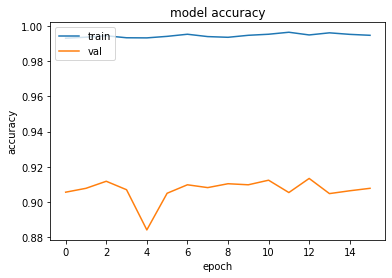

In [ ]:
plt.plot(glove_model.history['accuracy'])
plt.plot(glove_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

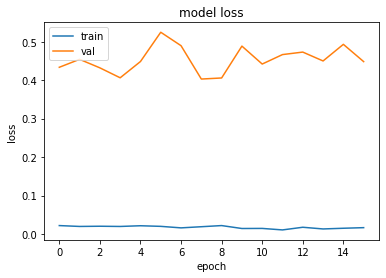

In [ ]:
plt.plot(glove_model.history['loss'])
plt.plot(glove_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

# Boosting

In [ ]:
from xgboost import XGBClassifier

xgboost_2 = XGBClassifier(n_estimators = 1000, learning_rate = 0.01).fit(X_train, y_train, early_stopping_rounds = 10, eval_set = [(X_test, y_test)],verbose = False)
score_xgb_2 = xgboost_2.score(X_test,y_test)
score_xgb_2

C:\Users\MSI\anaconda3\envs\GPU\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


0.904

In [ ]:
#Predict the response for test dataset
y_boost_pred_2 = xgboost_2.predict(X_test)

In [ ]:
# Print classification report
print(classification_report(y_test, y_boost_pred_2))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90      2476
           1       0.92      0.89      0.90      2524

    accuracy                           0.90      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.90      0.90      0.90      5000



In [ ]:
cmb_2 = confusion_matrix(y_test,y_boost_pred_2)
cmb_2

array([[2281,  195],
       [ 285, 2239]], dtype=int64)

Text(0.5, 1.0, 'Confusion Matrix Glove for Sentiment Classification after Boosting')

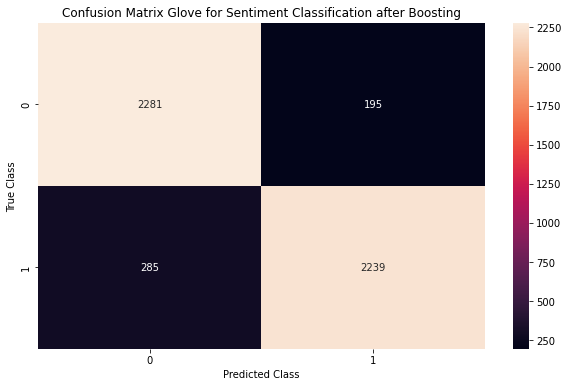

In [ ]:
fig = plt.figure(figsize = (10, 6))
sns.heatmap(cmb_2, annot = True,fmt = "d")

# Labeling the X-axis
plt.xlabel("Predicted Class")

# Labeling the Y-axis
plt.ylabel("True Class")

# Give a title to the graph
plt.title("Confusion Matrix Glove for Sentiment Classification after Boosting")